In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Imports

In [3]:
# TENSORFLOW #
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
from tensorflow_addons import image
import tensorflow_addons as tfa

# Other
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tabulate as tbl

In [4]:
# Load a dataset
(train, valid, test), metadata = tfds.load('cassava', # Plants
                              split = ['train', 'test', 'validation'],
                              as_supervised = True, # Get labels
                              shuffle_files=True, 
                              with_info = True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5656 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteH7F10J/cassava-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/1885 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteH7F10J/cassava-test.tfrecord*...:   0%|          |…

Generating validation examples...:   0%|          | 0/1889 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cassava/0.1.0.incompleteH7F10J/cassava-validation.tfrecord*...:   0%|     …

Dataset cassava downloaded and prepared to /root/tensorflow_datasets/cassava/0.1.0. Subsequent calls will reuse this data.


In [5]:
# Set sizes
train_size = metadata.splits['train'].num_examples
valid_size = metadata.splits['validation'].num_examples
test_size = metadata.splits['test'].num_examples

# Check details
print(f'Training set size: {train_size} | Validation set size: {valid_size} | Testing set size: {test_size}')

Training set size: 5656 | Validation set size: 1889 | Testing set size: 1885


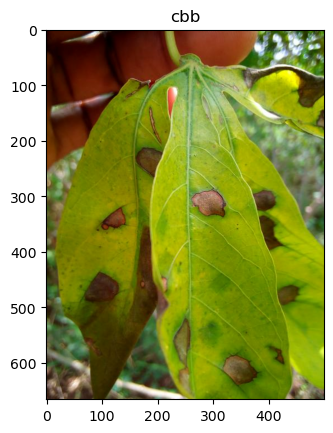

In [6]:
# Convert numbers into labels
get_label_name = metadata.features['label'].int2str

# Show an image
for image,label in train.take(1):
    # Plot the image
    plt.imshow(image)
    # Set the label as the title
    plt.title(get_label_name(label))

Before beginning the project, it's important to understand the distribution of at least the training set's labels, as it should be relatively similar in the validation and testing sets.

In [7]:
# Find the number of classes
num_classes = metadata.features['label'].num_classes
# Find the class labels
class_names = metadata.features["label"].names

# Check
print(f'There are {num_classes} classes in the Cassava dataset. The labels are: {class_names}.')

There are 5 classes in the Cassava dataset. The labels are: ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy'].


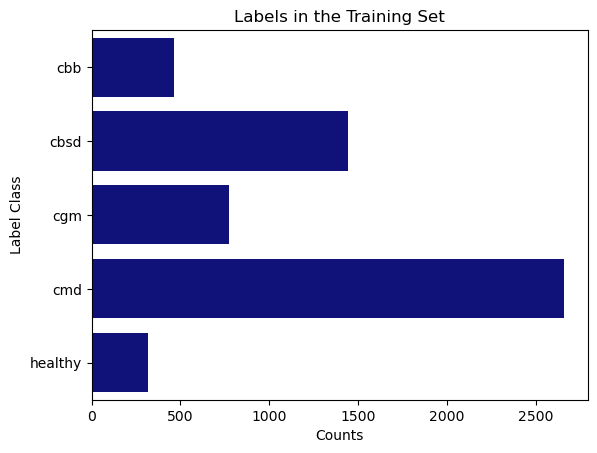

<Figure size 1200x1000 with 0 Axes>

In [8]:
# Hold the list of training labels
training_labels = []

# Access all the labels
for images, labels in train.take(-1):
    training_labels.append(get_label_name(labels.numpy()))
    
# Create a counter
label_counts = Counter(training_labels)

# Ordered keys
ordered_labels = sorted(label_counts.keys())

# Display breakdown of training labels
sns.barplot(x = [label_counts[k] for k in ordered_labels],
            y = ordered_labels,
            orient = 'h',
            color = 'darkblue')

# Titles
plt.xlabel('Counts')
plt.ylabel('Label Class')
plt.title('Labels in the Training Set')

# Show
plt.figure(figsize=(12,10))
plt.show()

The dataset is imbalanced, but the point of using deep learning is that it's typically a more robust method that you can avoid performing cross-validation on it. Instead, we use hold out datasets (train, validation, and testing triplet) and large amounts of training data. We will keep with this tactic for the rest of the notebook. (That's not to say that you can't use cross-validation, because you can. The point is not to, though.)

In [9]:
# Image size
img_size = 224

# Normalize function
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [img_size, img_size])
    # Normalize
    image = (image / 255.0)
    return image, label

In [18]:
# Calculate rotation angles
angle_vals = np.array([5.0, 15.0, 25.0, 45.0, 120.0, 165.0, 250.0]) # Base angles

# Augmentation
def augmenter(image, label):
    # Normalize - call this first
    image, label = normalize(image, label)
    # Rotate
    rotation = (np.random.choice(angle_vals) * np.pi / 180.0).astype(np.float32)
    image = tfa.image.rotate(image, angles = rotation, interpolation = "NEAREST")
    # Brightness
    image = tf.image.random_brightness(image, 0.5)
    # Return image and label
    return image, label
    

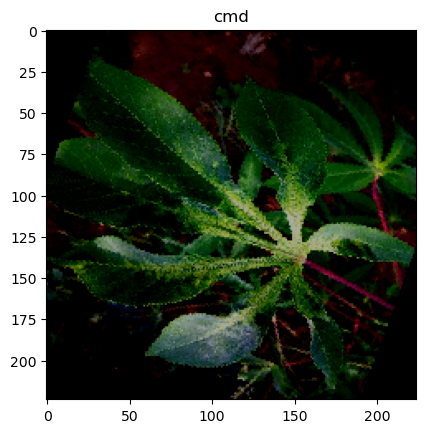

In [20]:
# Show an example of an augmented image
for image, label in train.take(1):
    img, lbl = augmenter(image, label)
    plt.imshow(img)
    plt.title(get_label_name(lbl))

### Create Data Pipelines

In [21]:
# Batch size
batch = 32

# Build the pipelines
num_training_examples = train_size // 100

# Training
training_batch = train.shuffle(num_training_examples//4).map(augmenter).batch(batch).prefetch(1)

# Validation
validation_batch = valid.shuffle(num_training_examples//4).map(augmenter).batch(batch).prefetch(1)

# Test
testing_batch = test.shuffle(num_training_examples//4).map(augmenter).batch(batch).prefetch(1)

## Build a Basic Model

This will be a very simple sequential feed forward model. We will use the following layers:
 - Dense
 - Conv2D
 - MaxPooling2D
 - Flatten
 
 The order of layers matters: Conv2D > MaxPooling2D > Flatten > Dense.
 
 Between each layer, the size of the tensor has to be tracked.

In [190]:
# Create a sequential model
model = Sequential([Conv2D(16, 3, padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D(), # MaxPooling2D
                    Conv2D(32, 3, padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D(), # MaxPooling2D
                    Conv2D(64, 3, padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D(), # MaxPooling2D
                    Flatten(), # Flatten
                    Dense(num_classes, activation = 'softmax')])

In [194]:
# Compile the model
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Model build
model.build((None, 224, 224, 3))

# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

### Model Training

In [196]:
# Epochs
EPOCHS = 20

# Stop training when there is no improvement in the validation loss for 5 consecutive epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Fit the model
history = model.fit(training_batch,
                    validation_data = validation_batch,
                    epochs = EPOCHS,
                    callbacks = [early_stopping])


Epoch 1/20
177/177 [==============================] - 217s 1s/step - loss: 1.1702 - accuracy: 0.5661 - val_loss: 1.2033 - val_accuracy: 0.5427
Epoch 2/20
177/177 [==============================] - 215s 1s/step - loss: 1.0920 - accuracy: 0.5918 - val_loss: 1.1830 - val_accuracy: 0.5416
Epoch 3/20
177/177 [==============================] - 205s 1s/step - loss: 0.9936 - accuracy: 0.6277 - val_loss: 1.2488 - val_accuracy: 0.5337
Epoch 4/20
177/177 [==============================] - 203s 1s/step - loss: 0.8095 - accuracy: 0.6955 - val_loss: 1.2585 - val_accuracy: 0.5629
Epoch 5/20
177/177 [==============================] - 207s 1s/step - loss: 0.6046 - accuracy: 0.7779 - val_loss: 1.7431 - val_accuracy: 0.5130
Epoch 6/20
177/177 [==============================] - 215s 1s/step - loss: 0.4086 - accuracy: 0.8635 - val_loss: 2.1513 - val_accuracy: 0.5156
Epoch 7/20
177/177 [==============================] - 213s 1s/step - loss: 0.2666 - accuracy: 0.9141 - val_loss: 3.0509 - val_accuracy: 0.4950

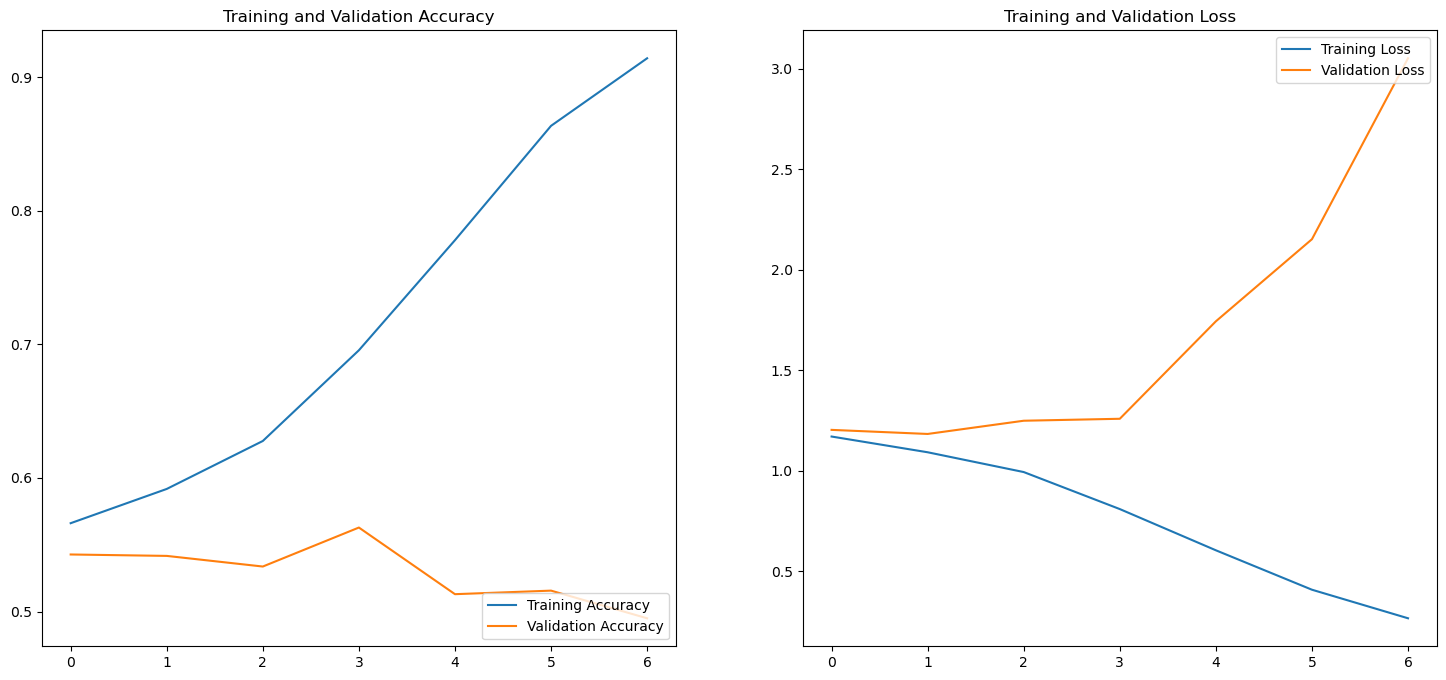

In [199]:
# Visualization of accuracies and losses
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This is some pretty serious overfitting. I'll perform a quick inference exercise to see how bad things actually are, but the model will need to be tweaked in order to improve performance.

### Inference

1/1 [==============================] - 0s 486ms/step


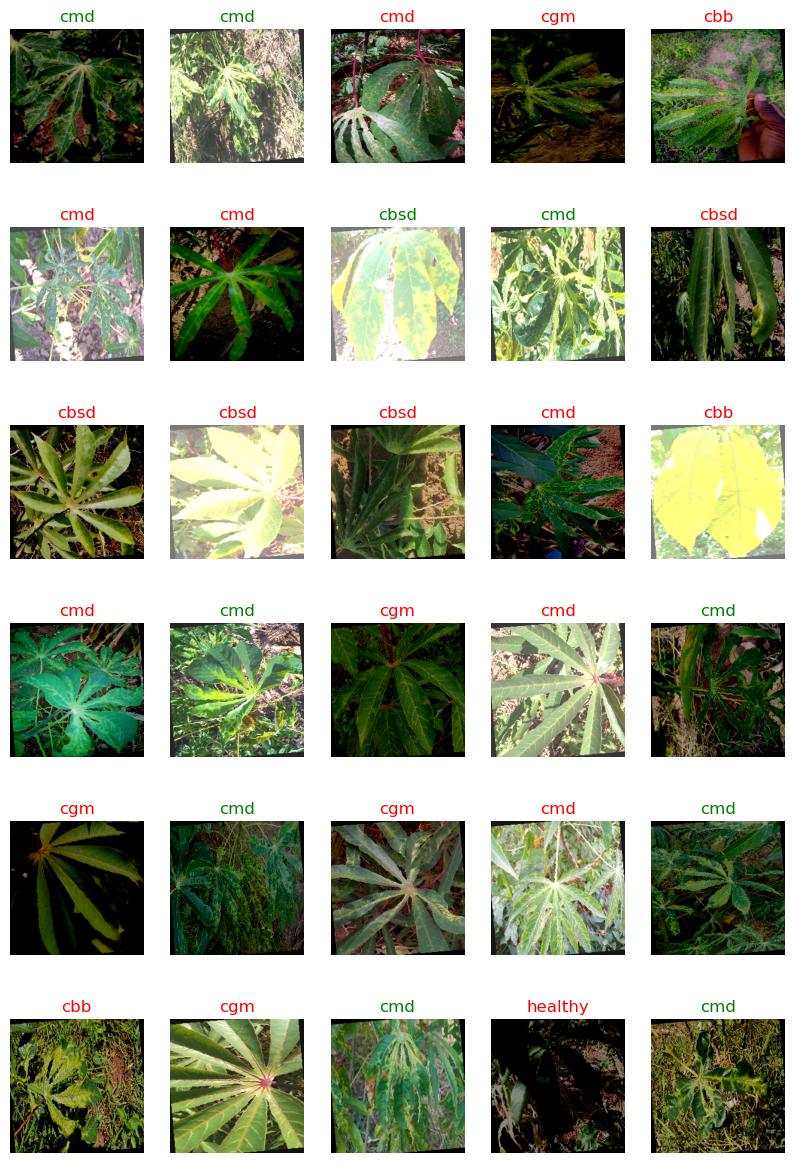

In [201]:
for image_batch, label_batch in testing_batch.take(1):
    ps = model.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()


plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')

## Model 2

This version of the model will use the same layers with the addition of a dropout layer, but there will be a slight change in architecture.

In [203]:
# Second model
model2 = Sequential([Conv2D(16, 3, padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D(), # MaxPooling2D
                    Conv2D(32, 3, padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D(), # MaxPooling2D
                    Conv2D(64, 3, padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D(), # MaxPooling2D
                    Flatten(), # Flatten
                    Dense(128, activation = 'relu'),# Dense
                    Dropout(0.2), # Dropout layer
                    Dense(num_classes, activation = 'softmax')])

# Compile the model
model2.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Model build
model2.build((None, 224, 224, 3))

# Summary
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)      

In [204]:
# Fit the model
history2 = model2.fit(training_batch,
                      validation_data = validation_batch,
                      epochs = EPOCHS,
                      callbacks = [early_stopping])

Epoch 1/20
177/177 [==============================] - 218s 1s/step - loss: 1.3163 - accuracy: 0.4949 - val_loss: 1.2997 - val_accuracy: 0.4875
Epoch 2/20
177/177 [==============================] - 219s 1s/step - loss: 1.1588 - accuracy: 0.5723 - val_loss: 1.2874 - val_accuracy: 0.4960
Epoch 3/20
177/177 [==============================] - 235s 1s/step - loss: 1.0983 - accuracy: 0.5995 - val_loss: 1.1395 - val_accuracy: 0.5793
Epoch 4/20
177/177 [==============================] - 219s 1s/step - loss: 1.0276 - accuracy: 0.6163 - val_loss: 1.1279 - val_accuracy: 0.5798
Epoch 5/20
177/177 [==============================] - 219s 1s/step - loss: 0.9552 - accuracy: 0.6381 - val_loss: 1.2403 - val_accuracy: 0.5576
Epoch 6/20
177/177 [==============================] - 239s 1s/step - loss: 0.8437 - accuracy: 0.6757 - val_loss: 1.2945 - val_accuracy: 0.5751
Epoch 7/20
177/177 [==============================] - 217s 1s/step - loss: 0.7205 - accuracy: 0.7252 - val_loss: 1.2432 - val_accuracy: 0.5867

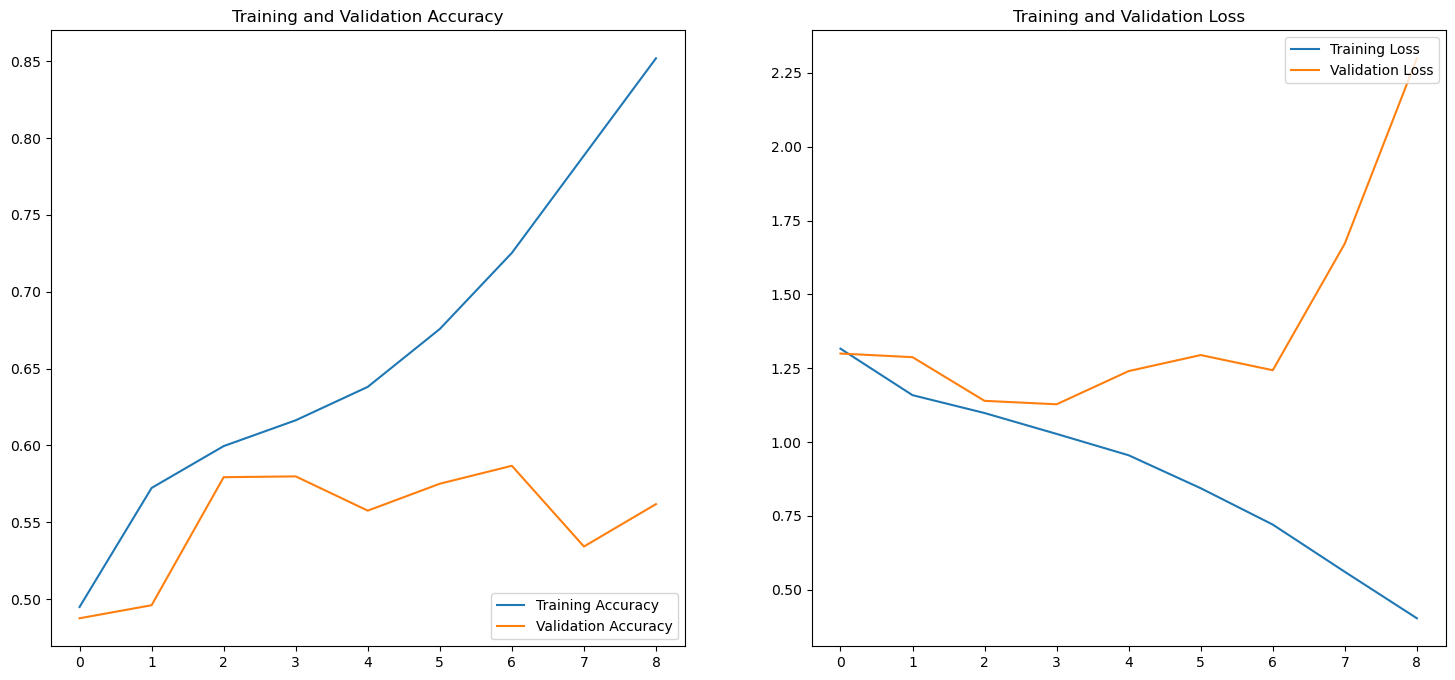

In [205]:
# Visualization of accuracies and losses
training_accuracy = history2.history['accuracy']
validation_accuracy = history2.history['val_accuracy']

training_loss = history2.history['loss']
validation_loss = history2.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Again, there is evidence of overfitting. So, clearly simple adjustments to architecture are not enough, though admittedly the performance seems somewhat better on this model than the previous one.

### Inference

1/1 [==============================] - 0s 396ms/step


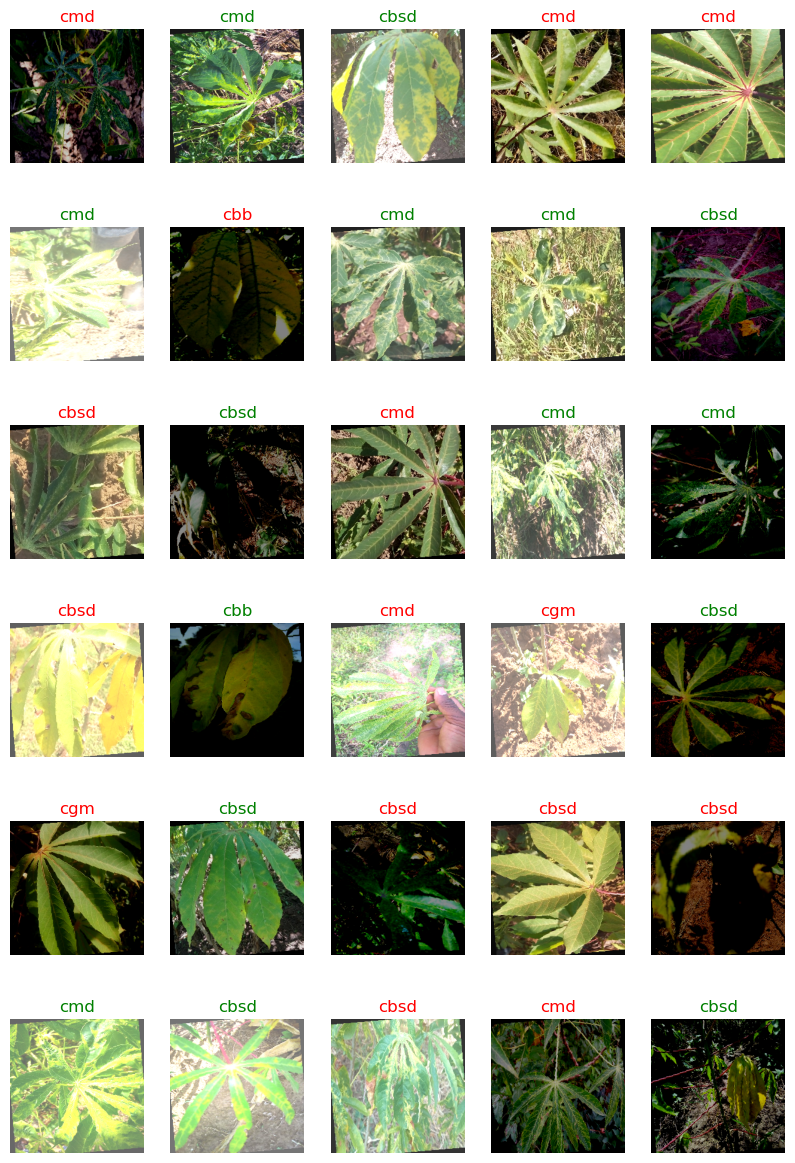

In [206]:
for image_batch, label_batch in testing_batch.take(1):
    ps = model2.predict(image_batch)
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()


plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    color = 'green' if np.argmax(ps[n]) == labels[n] else 'red'
    plt.title(class_names[np.argmax(ps[n])], color=color)
    plt.axis('off')

## Model 3

This version will include BatchNormalization and remove the Dropout layers. Also, the kernel values

In [22]:
# Second model
model3 = Sequential([Conv2D(64, (5, 5), padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D((2,2)), # MaxPooling2D
                    BatchNormalization(), # BatchNormalization
                    Conv2D(64, (5, 5), padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D((2,2)), # MaxPooling2D
                    BatchNormalization(), # BatchNormalization
                    Conv2D(128, (5, 5), padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D((2,2)), # MaxPooling2D
                    BatchNormalization(), # BatchNormalization
                    Conv2D(256, (5, 5), padding = 'same', activation = 'relu'), # Convolutional2D layer
                    MaxPooling2D((2,2)), # MaxPooling2D
                    Flatten(), # Flatten
                    Dense(1024, activation = 'relu'),# Dense
                    Dense(num_classes, activation = 'softmax')])

# Compile the model
model3.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Model build
model3.build((None, 224, 224, 3))

# Summary
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                        

In [24]:
# Epochs
e = 20

# Fit the model - removing early stopping
history3 = model3.fit(training_batch,
                      validation_data = validation_batch,
                      epochs = e)

Epoch 1/20
177/177 [==============================] - 1062s 6s/step - loss: 7.1554 - accuracy: 0.3909 - val_loss: 1.4719 - val_accuracy: 0.4700
Epoch 2/20
177/177 [==============================] - 1052s 6s/step - loss: 1.3499 - accuracy: 0.4996 - val_loss: 1.4973 - val_accuracy: 0.4435
Epoch 3/20
177/177 [==============================] - 1036s 6s/step - loss: 1.2605 - accuracy: 0.5352 - val_loss: 1.4739 - val_accuracy: 0.4881
Epoch 4/20
177/177 [==============================] - 1034s 6s/step - loss: 1.2050 - accuracy: 0.5467 - val_loss: 1.3389 - val_accuracy: 0.4912
Epoch 5/20
177/177 [==============================] - 1037s 6s/step - loss: 1.1474 - accuracy: 0.5705 - val_loss: 1.4588 - val_accuracy: 0.3714
Epoch 6/20
177/177 [==============================] - 1037s 6s/step - loss: 1.0880 - accuracy: 0.5895 - val_loss: 1.2485 - val_accuracy: 0.5024
Epoch 7/20
177/177 [==============================] - 1037s 6s/step - loss: 1.0759 - accuracy: 0.6029 - val_loss: 1.3770 - val_accuracy:

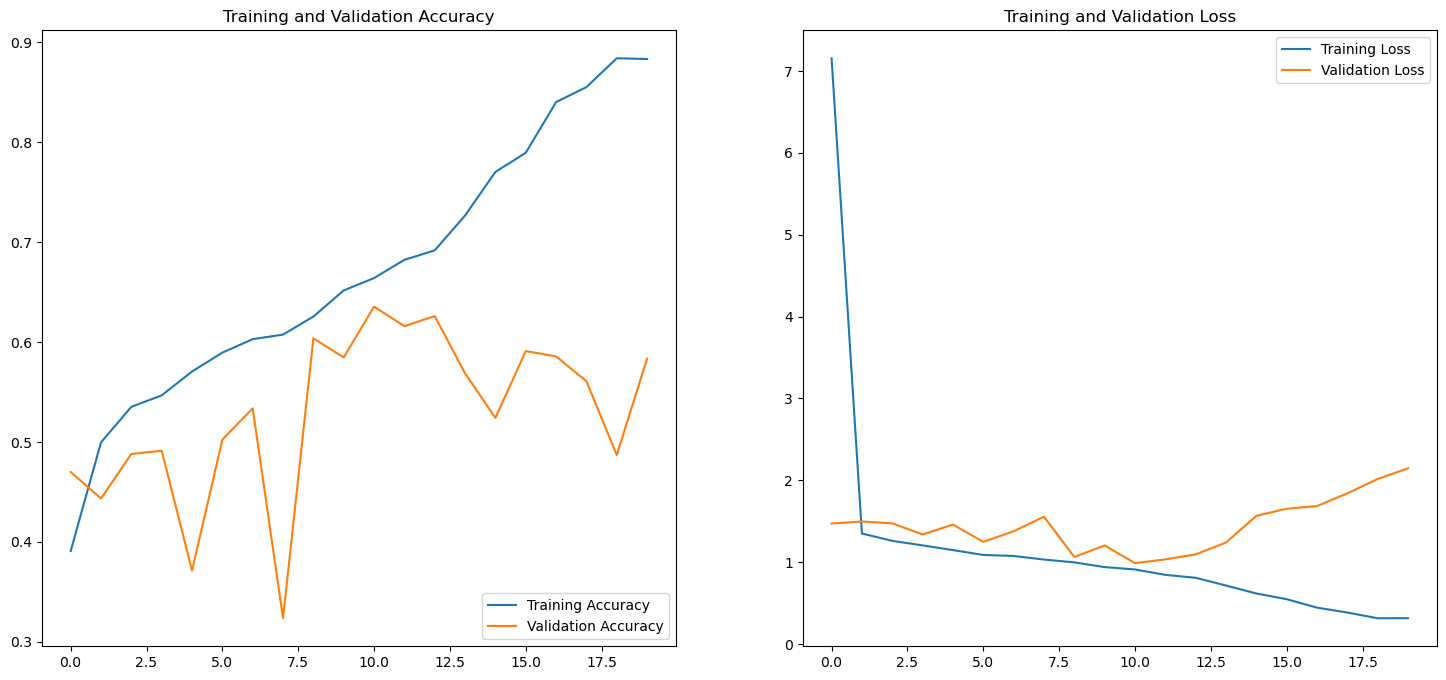

In [25]:
# Visualization of accuracies and losses
training_accuracy = history3.history['accuracy']
validation_accuracy = history3.history['val_accuracy']

training_loss = history3.history['loss']
validation_loss = history3.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

These results are a definite improvement over the previous two models, but around the 11th or 12th epoch, you begin to see overfitting. So, while I will make no further adjustments to the model, I will state that there's room for improvement:

- Adjusting a learning rate
- Changing the optimizer
- Changing the hidden layer sizes

Anyway, now I will make predictions from the model on the training data.

In [27]:
# Save the model
saved_model_path = './model3.h5'
model3.save(saved_model_path)

In [44]:
# Evaluate
results = model3.evaluate(testing_batch)

# Dictionary
results_dict = dict(zip(model3.metrics_names, results))

60/60 [==============================] - 83s 1s/step - loss: 2.2112 - accuracy: 0.5807


In [46]:
# print results
for k,v in results_dict.items():
    print(f'{k}: {v}')

loss: 2.2111592292785645
accuracy: 0.5807305574417114
